# 1. Installing Packages and Datasets

In [1]:
# Installing necessary packages
# !pip install kagglehub pandas matplotlib seaborn ipywidgets python-dotenv transformers langchain-openai langchain-community langchain-chroma gradio notebook

In [2]:
# Import 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import plotly.express as px


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("asaniczka/full-tmdb-tv-shows-dataset-2023-150k-shows")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\ADMIN\.cache\kagglehub\datasets\asaniczka\full-tmdb-tv-shows-dataset-2023-150k-shows\versions\22


In [4]:
# path = r'C:\Users\ADMIN\.cache\kagglehub\datasets\asaniczka\full-tmdb-tv-shows-dataset-2023-150k-shows\versions\22'

file_path = os.path.join(path, "tv_show.csv")
file_path

'C:\\Users\\ADMIN\\.cache\\kagglehub\\datasets\\asaniczka\\full-tmdb-tv-shows-dataset-2023-150k-shows\\versions\\22\\tv_show.csv'

In [5]:
shows = pd.read_csv(file_path)
shows.head(5)

,id,name,number_of_seasons,number_of_episodes,original_language,vote_count,vote_average,overview,adult,backdrop_path,...,tagline,genres,created_by,languages,networks,origin_country,spoken_languages,production_companies,production_countries,episode_run_time
0,1399,Game of Thrones,8,73,en,21857,8.442,Seven noble families fight for control of the ...,False,/2OMB0ynKlyIenMJWI2Dy9IWT4c.jpg,...,Winter Is Coming,"Sci-Fi & Fantasy, Drama, Action & Adventure","David Benioff, D.B. Weiss",en,HBO,US,English,"Revolution Sun Studios, Television 360, Genera...","United Kingdom, United States of America",0
1,71446,Money Heist,3,41,es,17836,8.257,"To carry out the biggest heist in history, a m...",False,/gFZriCkpJYsApPZEF3jhxL4yLzG.jpg,...,The perfect robbery.,"Crime, Drama",Álex Pina,es,"Netflix, Antena 3",ES,Español,Vancouver Media,Spain,70
2,66732,Stranger Things,4,34,en,16161,8.624,"When a young boy vanishes, a small town uncove...",False,/2MaumbgBlW1NoPo3ZJO38A6v7OS.jpg,...,Every ending has a beginning.,"Drama, Sci-Fi & Fantasy, Mystery","Matt Duffer, Ross Duffer",en,Netflix,US,English,"21 Laps Entertainment, Monkey Massacre Product...",United States of America,0
3,1402,The Walking Dead,11,177,en,15432,8.121,Sheriff's deputy Rick Grimes awakens from a co...,False,/x4salpjB11umlUOltfNvSSrjSXm.jpg,...,Fight the dead. Fear the living.,"Action & Adventure, Drama, Sci-Fi & Fantasy",Frank Darabont,en,AMC,US,English,"AMC Studios, Circle of Confusion, Valhalla Mot...",United States of America,42
4,63174,Lucifer,6,93,en,13870,8.486,"Bored and unhappy as the Lord of Hell, Lucifer...",False,/aDBRtunw49UF4XmqfyNuD9nlYIu.jpg,...,It's good to be bad.,"Crime, Sci-Fi & Fantasy",Tom Kapinos,en,"FOX, Netflix",US,English,"Warner Bros. Television, DC Entertainment, Jer...",United States of America,45


# 2. Data Preprocessing

In [6]:
# Remove adult content and reset index to avoid chained assignment
shows = shows.loc[shows['adult'] == False].copy()

## Removing unwanted columns

In [ ]:
drop_columns = [
    "in_production", "type", "origin_country", "spoken_languages",
    "production_companies", "production_countries", "episode_run_time", "adult", "networks"
]
shows.drop(columns=drop_columns, inplace=True)

## Finding the relation between the missing values from differenct columns

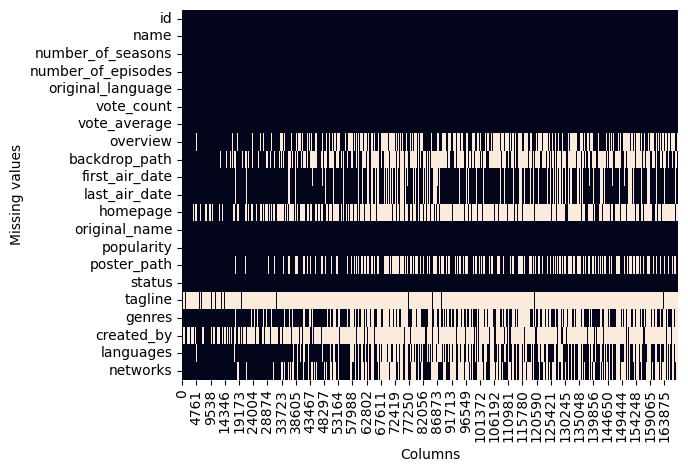

In [8]:
ax = plt.axes()
sns.heatmap(shows.isna().transpose(), cbar=False, ax=ax)

plt.xlabel('Columns')
plt.ylabel('Missing values')

plt.show()

## Find the missing values and Try to fill it

In [9]:
shows['missing_overview'] = np.where(shows['overview'].isna(), 1, 0)


In [10]:
shows['missing_overview'].value_counts()

missing_overview
0    91811
1    74789
Name: count, dtype: int64

### Fetching missing overview columns with tmbd api key

In [11]:
import requests
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

# TMDB API key 
TMDB_API_KEY = '8d68023e54e4be1062f6a33c1036b464'

# Function to fetch movie overview
def fetch_movie_overview(movie_id):
    url = f"https://api.themoviedb.org/3/movie/{movie_id}?api_key={TMDB_API_KEY}&language=en-US"
    
    try:
        response = requests.get(url)
        data = response.json()

        if response.status_code == 200 and "overview" in data:
            return movie_id, data['overview']
        else:
            return movie_id, None
    except Exception as e:
        print(f"Error fetching movie {movie_id}: {e}")
        return movie_id, None
missing_movies = shows[shows["missing_overview"] == 1]["id"].tolist()

# Multi-threading setup
num_threads = 10  # Adjust based on your internet speed & API limits

updated_overviews = {}
with ThreadPoolExecutor(max_workers=num_threads) as executor:
    futures = {executor.submit(fetch_movie_overview, movie_id): movie_id for movie_id in missing_movies}

    for future in tqdm(as_completed(futures), total=len(futures)):
        movie_id, overview = future.result()
        if overview:
            updated_overviews[movie_id] = overview

# Update DataFrame
for movie_id, overview in updated_overviews.items():
    shows.loc[shows["id"] == movie_id, "overview"] = overview
    shows.loc[shows['id'] == movie_id, "missing_overview"] = 0

print("Overview update complete!")

100%|██████████| 74789/74789 [56:35<00:00, 22.02it/s]  


Overview update complete!


In [12]:
shows['overview'].isna().sum()

32357

### Generate own overview with title and tagline

In [13]:
def generate_overview(row):
    if pd.notna(row['overview']):
        return row['overview']
    
    # Construct an overview based on available columns
    genre_part = f"It belongs to the {row['genres']} genre." if pd.notna(row['genres']) else ""
    tagline_part = f" Tagline: {row['tagline']}." if pd.notna(row['tagline']) else ""
    
    if genre_part or tagline_part:
        new_overview = f"{row['name']} - {genre_part}{tagline_part}".strip()
    else:
        new_overview = f"The TV show '{row['name']}' has no official description available."

    shows.at[row.name, 'missing_overview'] = 0 if new_overview else 1

    return new_overview

# Apply the function to fill missing overviews
shows['overview'] = shows.apply(generate_overview, axis=1)

In [14]:
shows['overview'].isna().sum()

0

### Remove Overview with very small Description

In [15]:
shows['words_in_overview'] = shows['overview'].str.split().str.len()
shows

,id,name,number_of_seasons,number_of_episodes,original_language,vote_count,vote_average,overview,backdrop_path,first_air_date,...,popularity,poster_path,status,tagline,genres,created_by,languages,networks,missing_overview,words_in_overview
0,1399,Game of Thrones,8,73,en,21857,8.442,Seven noble families fight for control of the ...,/2OMB0ynKlyIenMJWI2Dy9IWT4c.jpg,2011-04-17,...,1083.917,/1XS1oqL89opfnbLl8WnZY1O1uJx.jpg,Ended,Winter Is Coming,"Sci-Fi & Fantasy, Drama, Action & Adventure","David Benioff, D.B. Weiss",en,HBO,0,56
1,71446,Money Heist,3,41,es,17836,8.257,"To carry out the biggest heist in history, a m...",/gFZriCkpJYsApPZEF3jhxL4yLzG.jpg,2017-05-02,...,96.354,/reEMJA1uzscCbkpeRJeTT2bjqUp.jpg,Ended,The perfect robbery.,"Crime, Drama",Álex Pina,es,"Netflix, Antena 3",0,85
2,66732,Stranger Things,4,34,en,16161,8.624,"When a young boy vanishes, a small town uncove...",/2MaumbgBlW1NoPo3ZJO38A6v7OS.jpg,2016-07-15,...,185.711,/49WJfeN0moxb9IPfGn8AIqMGskD.jpg,Returning Series,Every ending has a beginning.,"Drama, Sci-Fi & Fantasy, Mystery","Matt Duffer, Ross Duffer",en,Netflix,0,22
3,1402,The Walking Dead,11,177,en,15432,8.121,Sheriff's deputy Rick Grimes awakens from a co...,/x4salpjB11umlUOltfNvSSrjSXm.jpg,2010-10-31,...,489.746,/n7PVu0hSz2sAsVekpOIoCnkWlbn.jpg,Ended,Fight the dead. Fear the living.,"Action & Adventure, Drama, Sci-Fi & Fantasy",Frank Darabont,en,AMC,0,32
4,63174,Lucifer,6,93,en,13870,8.486,"Bored and unhappy as the Lord of Hell, Lucifer...",/aDBRtunw49UF4XmqfyNuD9nlYIu.jpg,2016-01-25,...,416.668,/ekZobS8isE6mA53RAiGDG93hBxL.jpg,Ended,It's good to be bad.,"Crime, Sci-Fi & Fantasy",Tom Kapinos,en,"FOX, Netflix",0,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168634,239099,母乳酱想要喷出来,1,1,zh,0,0.000,The TV show '母乳酱想要喷出来' has no official descrip...,NaN,2023-03-03,...,1.400,NaN,Returning Series,NaN,NaN,NaN,NaN,NaN,0,9
168635,241205,Barbie Dream Squad,1,1,es,0,0.000,The TV show 'Barbie Dream Squad' has no offici...,NaN,NaN,...,0.600,/vvm7p60THjcYdnXnXfjCgwPeime.jpg,Ended,NaN,NaN,"Dee Shipley, Blair Davidson",NaN,NaN,0,11
168636,240696,Picasso,1,1,bn,0,0.000,"Murder, art and a journalist's relentless ques...",/fseBBbvHtdcZS5M7bSjOxYsVe5.jpg,2023-11-30,...,1.895,/ifDs1gBunsaN3lAG4Imc94JcfVD.jpg,Returning Series,NaN,Crime,NaN,bn,NaN,0,16
168637,240697,女子大生危険なアルバイト,1,1,en,0,0.000,A college student gets into trouble when she m...,NaN,1990-02-10,...,0.600,/9EO55cThzp98PaM9iVRoZPXjIZ8.jpg,Returning Series,NaN,NaN,NaN,NaN,NaN,0,21


In [16]:
word_counts = shows['words_in_overview'].value_counts().reset_index()
word_counts.columns = ["words_in_overview", "count"]

word_counts = word_counts.sort_values('words_in_overview')

fig = px.histogram(word_counts, x="words_in_overview", y="count",  title='Count of words in Overview')

fig.update_xaxes(title_text='Number of Words')
fig.update_yaxes(title_text='Count')

fig.show()

In [17]:
shows.loc[shows['words_in_overview'].between(0,5), "overview"]

7368           2-minute shorts about Gravity Falls.
8550                      By gangatv Julia vs Julia
11287                        Care Bears and Cousins
11744                Swedish version of Taskmaster.
12350                                   Gandhipuram
                            ...                    
168594                      Romance Meets Prejudice
168597             Little Fox动画故事Level04：Thumbelina
168608           Little Fox动画故事Level04：Rocket Grild
168609    Little Fox动画故事Level04：Fun at Kids Central
168638           Short-lives series on Youtube Red.
Name: overview, Length: 2455, dtype: object

In [18]:
shows_overview_5_words = shows[shows['words_in_overview'] >=5]
shows_overview_5_words

,id,name,number_of_seasons,number_of_episodes,original_language,vote_count,vote_average,overview,backdrop_path,first_air_date,...,popularity,poster_path,status,tagline,genres,created_by,languages,networks,missing_overview,words_in_overview
0,1399,Game of Thrones,8,73,en,21857,8.442,Seven noble families fight for control of the ...,/2OMB0ynKlyIenMJWI2Dy9IWT4c.jpg,2011-04-17,...,1083.917,/1XS1oqL89opfnbLl8WnZY1O1uJx.jpg,Ended,Winter Is Coming,"Sci-Fi & Fantasy, Drama, Action & Adventure","David Benioff, D.B. Weiss",en,HBO,0,56
1,71446,Money Heist,3,41,es,17836,8.257,"To carry out the biggest heist in history, a m...",/gFZriCkpJYsApPZEF3jhxL4yLzG.jpg,2017-05-02,...,96.354,/reEMJA1uzscCbkpeRJeTT2bjqUp.jpg,Ended,The perfect robbery.,"Crime, Drama",Álex Pina,es,"Netflix, Antena 3",0,85
2,66732,Stranger Things,4,34,en,16161,8.624,"When a young boy vanishes, a small town uncove...",/2MaumbgBlW1NoPo3ZJO38A6v7OS.jpg,2016-07-15,...,185.711,/49WJfeN0moxb9IPfGn8AIqMGskD.jpg,Returning Series,Every ending has a beginning.,"Drama, Sci-Fi & Fantasy, Mystery","Matt Duffer, Ross Duffer",en,Netflix,0,22
3,1402,The Walking Dead,11,177,en,15432,8.121,Sheriff's deputy Rick Grimes awakens from a co...,/x4salpjB11umlUOltfNvSSrjSXm.jpg,2010-10-31,...,489.746,/n7PVu0hSz2sAsVekpOIoCnkWlbn.jpg,Ended,Fight the dead. Fear the living.,"Action & Adventure, Drama, Sci-Fi & Fantasy",Frank Darabont,en,AMC,0,32
4,63174,Lucifer,6,93,en,13870,8.486,"Bored and unhappy as the Lord of Hell, Lucifer...",/aDBRtunw49UF4XmqfyNuD9nlYIu.jpg,2016-01-25,...,416.668,/ekZobS8isE6mA53RAiGDG93hBxL.jpg,Ended,It's good to be bad.,"Crime, Sci-Fi & Fantasy",Tom Kapinos,en,"FOX, Netflix",0,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168634,239099,母乳酱想要喷出来,1,1,zh,0,0.000,The TV show '母乳酱想要喷出来' has no official descrip...,NaN,2023-03-03,...,1.400,NaN,Returning Series,NaN,NaN,NaN,NaN,NaN,0,9
168635,241205,Barbie Dream Squad,1,1,es,0,0.000,The TV show 'Barbie Dream Squad' has no offici...,NaN,NaN,...,0.600,/vvm7p60THjcYdnXnXfjCgwPeime.jpg,Ended,NaN,NaN,"Dee Shipley, Blair Davidson",NaN,NaN,0,11
168636,240696,Picasso,1,1,bn,0,0.000,"Murder, art and a journalist's relentless ques...",/fseBBbvHtdcZS5M7bSjOxYsVe5.jpg,2023-11-30,...,1.895,/ifDs1gBunsaN3lAG4Imc94JcfVD.jpg,Returning Series,NaN,Crime,NaN,bn,NaN,0,16
168637,240697,女子大生危険なアルバイト,1,1,en,0,0.000,A college student gets into trouble when she m...,NaN,1990-02-10,...,0.600,/9EO55cThzp98PaM9iVRoZPXjIZ8.jpg,Returning Series,NaN,NaN,NaN,NaN,NaN,0,21


In [19]:
shows_overview_5_words.shape

(164647, 23)

### Clean Genres

In [20]:
len(shows_overview_5_words['genres'].unique())

2215

In [21]:
shows_overview_5_words['genres'].head(15)

0     Sci-Fi & Fantasy, Drama, Action & Adventure
1                                    Crime, Drama
2                Drama, Sci-Fi & Fantasy, Mystery
3     Action & Adventure, Drama, Sci-Fi & Fantasy
4                         Crime, Sci-Fi & Fantasy
5                           Crime, Drama, Mystery
6              Action & Adventure, Mystery, Drama
7                                    Drama, Crime
8                                           Drama
9                Sci-Fi & Fantasy, Mystery, Drama
10                        Drama, Sci-Fi & Fantasy
11                                         Comedy
12                        Drama, Sci-Fi & Fantasy
13                                          Drama
14    Sci-Fi & Fantasy, Action & Adventure, Drama
Name: genres, dtype: object

In [22]:
shows_overview_5_words["primary_genre"] = shows_overview_5_words["genres"].apply(lambda x: x.split(",")[0] if pd.notna(x) else "Unknown")

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_21656\2998723247.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [23]:
genres_counts = shows_overview_5_words["primary_genre"].value_counts().reset_index().sort_values("count", ascending=False)
genres_counts

,primary_genre,count
0,Unknown,67024
1,Drama,24091
2,Documentary,20465
3,Comedy,15266
4,Reality,9221
5,Animation,8707
6,Action & Adventure,3370
7,Crime,3336
8,Family,2530
9,Talk,2318


In [24]:
fig = px.bar(genres_counts, x="primary_genre", y='count', title="Most occuring Genre counts", color='count', color_continuous_scale='Magma')

fig.update_xaxes(tickangle=90)

fig.show()

In [25]:
shows_overview_5_words["genre_list"] = shows_overview_5_words["genres"].apply(lambda x: x.split(", ") if pd.notna(x) else [])
shows_overview_5_words

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_21656\2804529783.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,id,name,number_of_seasons,number_of_episodes,original_language,vote_count,vote_average,overview,backdrop_path,first_air_date,...,status,tagline,genres,created_by,languages,networks,missing_overview,words_in_overview,primary_genre,genre_list
0,1399,Game of Thrones,8,73,en,21857,8.442,Seven noble families fight for control of the ...,/2OMB0ynKlyIenMJWI2Dy9IWT4c.jpg,2011-04-17,...,Ended,Winter Is Coming,"Sci-Fi & Fantasy, Drama, Action & Adventure","David Benioff, D.B. Weiss",en,HBO,0,56,Sci-Fi & Fantasy,"[Sci-Fi & Fantasy, Drama, Action & Adventure]"
1,71446,Money Heist,3,41,es,17836,8.257,"To carry out the biggest heist in history, a m...",/gFZriCkpJYsApPZEF3jhxL4yLzG.jpg,2017-05-02,...,Ended,The perfect robbery.,"Crime, Drama",Álex Pina,es,"Netflix, Antena 3",0,85,Crime,"[Crime, Drama]"
2,66732,Stranger Things,4,34,en,16161,8.624,"When a young boy vanishes, a small town uncove...",/2MaumbgBlW1NoPo3ZJO38A6v7OS.jpg,2016-07-15,...,Returning Series,Every ending has a beginning.,"Drama, Sci-Fi & Fantasy, Mystery","Matt Duffer, Ross Duffer",en,Netflix,0,22,Drama,"[Drama, Sci-Fi & Fantasy, Mystery]"
3,1402,The Walking Dead,11,177,en,15432,8.121,Sheriff's deputy Rick Grimes awakens from a co...,/x4salpjB11umlUOltfNvSSrjSXm.jpg,2010-10-31,...,Ended,Fight the dead. Fear the living.,"Action & Adventure, Drama, Sci-Fi & Fantasy",Frank Darabont,en,AMC,0,32,Action & Adventure,"[Action & Adventure, Drama, Sci-Fi & Fantasy]"
4,63174,Lucifer,6,93,en,13870,8.486,"Bored and unhappy as the Lord of Hell, Lucifer...",/aDBRtunw49UF4XmqfyNuD9nlYIu.jpg,2016-01-25,...,Ended,It's good to be bad.,"Crime, Sci-Fi & Fantasy",Tom Kapinos,en,"FOX, Netflix",0,51,Crime,"[Crime, Sci-Fi & Fantasy]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168634,239099,母乳酱想要喷出来,1,1,zh,0,0.000,The TV show '母乳酱想要喷出来' has no official descrip...,NaN,2023-03-03,...,Returning Series,NaN,NaN,NaN,NaN,NaN,0,9,Unknown,[]
168635,241205,Barbie Dream Squad,1,1,es,0,0.000,The TV show 'Barbie Dream Squad' has no offici...,NaN,NaN,...,Ended,NaN,NaN,"Dee Shipley, Blair Davidson",NaN,NaN,0,11,Unknown,[]
168636,240696,Picasso,1,1,bn,0,0.000,"Murder, art and a journalist's relentless ques...",/fseBBbvHtdcZS5M7bSjOxYsVe5.jpg,2023-11-30,...,Returning Series,NaN,Crime,NaN,bn,NaN,0,16,Crime,[Crime]
168637,240697,女子大生危険なアルバイト,1,1,en,0,0.000,A college student gets into trouble when she m...,NaN,1990-02-10,...,Returning Series,NaN,NaN,NaN,NaN,NaN,0,21,Unknown,[]


## Add some columns

In [26]:
shows_overview_5_words['title_and_tagline'] = (
    np.where(shows_overview_5_words['tagline'].isna(), shows_overview_5_words['name'],
             shows_overview_5_words[['name', 'tagline']].astype(str).agg(": ".join, axis=1))
)
shows_overview_5_words

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_21656\3626999279.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,id,name,number_of_seasons,number_of_episodes,original_language,vote_count,vote_average,overview,backdrop_path,first_air_date,...,tagline,genres,created_by,languages,networks,missing_overview,words_in_overview,primary_genre,genre_list,title_and_tagline
0,1399,Game of Thrones,8,73,en,21857,8.442,Seven noble families fight for control of the ...,/2OMB0ynKlyIenMJWI2Dy9IWT4c.jpg,2011-04-17,...,Winter Is Coming,"Sci-Fi & Fantasy, Drama, Action & Adventure","David Benioff, D.B. Weiss",en,HBO,0,56,Sci-Fi & Fantasy,"[Sci-Fi & Fantasy, Drama, Action & Adventure]",Game of Thrones: Winter Is Coming
1,71446,Money Heist,3,41,es,17836,8.257,"To carry out the biggest heist in history, a m...",/gFZriCkpJYsApPZEF3jhxL4yLzG.jpg,2017-05-02,...,The perfect robbery.,"Crime, Drama",Álex Pina,es,"Netflix, Antena 3",0,85,Crime,"[Crime, Drama]",Money Heist: The perfect robbery.
2,66732,Stranger Things,4,34,en,16161,8.624,"When a young boy vanishes, a small town uncove...",/2MaumbgBlW1NoPo3ZJO38A6v7OS.jpg,2016-07-15,...,Every ending has a beginning.,"Drama, Sci-Fi & Fantasy, Mystery","Matt Duffer, Ross Duffer",en,Netflix,0,22,Drama,"[Drama, Sci-Fi & Fantasy, Mystery]",Stranger Things: Every ending has a beginning.
3,1402,The Walking Dead,11,177,en,15432,8.121,Sheriff's deputy Rick Grimes awakens from a co...,/x4salpjB11umlUOltfNvSSrjSXm.jpg,2010-10-31,...,Fight the dead. Fear the living.,"Action & Adventure, Drama, Sci-Fi & Fantasy",Frank Darabont,en,AMC,0,32,Action & Adventure,"[Action & Adventure, Drama, Sci-Fi & Fantasy]",The Walking Dead: Fight the dead. Fear the liv...
4,63174,Lucifer,6,93,en,13870,8.486,"Bored and unhappy as the Lord of Hell, Lucifer...",/aDBRtunw49UF4XmqfyNuD9nlYIu.jpg,2016-01-25,...,It's good to be bad.,"Crime, Sci-Fi & Fantasy",Tom Kapinos,en,"FOX, Netflix",0,51,Crime,"[Crime, Sci-Fi & Fantasy]",Lucifer: It's good to be bad.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168634,239099,母乳酱想要喷出来,1,1,zh,0,0.000,The TV show '母乳酱想要喷出来' has no official descrip...,NaN,2023-03-03,...,NaN,NaN,NaN,NaN,NaN,0,9,Unknown,[],母乳酱想要喷出来
168635,241205,Barbie Dream Squad,1,1,es,0,0.000,The TV show 'Barbie Dream Squad' has no offici...,NaN,NaN,...,NaN,NaN,"Dee Shipley, Blair Davidson",NaN,NaN,0,11,Unknown,[],Barbie Dream Squad
168636,240696,Picasso,1,1,bn,0,0.000,"Murder, art and a journalist's relentless ques...",/fseBBbvHtdcZS5M7bSjOxYsVe5.jpg,2023-11-30,...,NaN,Crime,NaN,bn,NaN,0,16,Crime,[Crime],Picasso
168637,240697,女子大生危険なアルバイト,1,1,en,0,0.000,A college student gets into trouble when she m...,NaN,1990-02-10,...,NaN,NaN,NaN,NaN,NaN,0,21,Unknown,[],女子大生危険なアルバイト


In [29]:
shows_overview_5_words['tagged_description'] = (
    shows_overview_5_words['id'].astype(str) + " " +
    shows_overview_5_words['overview'].str.replace("\n", " ")
)
shows_overview_5_words

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_21656\1623082011.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,id,name,number_of_seasons,number_of_episodes,original_language,vote_count,vote_average,overview,backdrop_path,first_air_date,...,genres,created_by,languages,networks,missing_overview,words_in_overview,primary_genre,genre_list,title_and_tagline,tagged_description
0,1399,Game of Thrones,8,73,en,21857,8.442,Seven noble families fight for control of the ...,/2OMB0ynKlyIenMJWI2Dy9IWT4c.jpg,2011-04-17,...,"Sci-Fi & Fantasy, Drama, Action & Adventure","David Benioff, D.B. Weiss",en,HBO,0,56,Sci-Fi & Fantasy,"[Sci-Fi & Fantasy, Drama, Action & Adventure]",Game of Thrones: Winter Is Coming,1399 Seven noble families fight for control of...
1,71446,Money Heist,3,41,es,17836,8.257,"To carry out the biggest heist in history, a m...",/gFZriCkpJYsApPZEF3jhxL4yLzG.jpg,2017-05-02,...,"Crime, Drama",Álex Pina,es,"Netflix, Antena 3",0,85,Crime,"[Crime, Drama]",Money Heist: The perfect robbery.,71446 To carry out the biggest heist in histor...
2,66732,Stranger Things,4,34,en,16161,8.624,"When a young boy vanishes, a small town uncove...",/2MaumbgBlW1NoPo3ZJO38A6v7OS.jpg,2016-07-15,...,"Drama, Sci-Fi & Fantasy, Mystery","Matt Duffer, Ross Duffer",en,Netflix,0,22,Drama,"[Drama, Sci-Fi & Fantasy, Mystery]",Stranger Things: Every ending has a beginning.,"66732 When a young boy vanishes, a small town ..."
3,1402,The Walking Dead,11,177,en,15432,8.121,Sheriff's deputy Rick Grimes awakens from a co...,/x4salpjB11umlUOltfNvSSrjSXm.jpg,2010-10-31,...,"Action & Adventure, Drama, Sci-Fi & Fantasy",Frank Darabont,en,AMC,0,32,Action & Adventure,"[Action & Adventure, Drama, Sci-Fi & Fantasy]",The Walking Dead: Fight the dead. Fear the liv...,1402 Sheriff's deputy Rick Grimes awakens from...
4,63174,Lucifer,6,93,en,13870,8.486,"Bored and unhappy as the Lord of Hell, Lucifer...",/aDBRtunw49UF4XmqfyNuD9nlYIu.jpg,2016-01-25,...,"Crime, Sci-Fi & Fantasy",Tom Kapinos,en,"FOX, Netflix",0,51,Crime,"[Crime, Sci-Fi & Fantasy]",Lucifer: It's good to be bad.,"63174 Bored and unhappy as the Lord of Hell, L..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168634,239099,母乳酱想要喷出来,1,1,zh,0,0.000,The TV show '母乳酱想要喷出来' has no official descrip...,NaN,2023-03-03,...,NaN,NaN,NaN,NaN,0,9,Unknown,[],母乳酱想要喷出来,239099 The TV show '母乳酱想要喷出来' has no official ...
168635,241205,Barbie Dream Squad,1,1,es,0,0.000,The TV show 'Barbie Dream Squad' has no offici...,NaN,NaN,...,NaN,"Dee Shipley, Blair Davidson",NaN,NaN,0,11,Unknown,[],Barbie Dream Squad,241205 The TV show 'Barbie Dream Squad' has no...
168636,240696,Picasso,1,1,bn,0,0.000,"Murder, art and a journalist's relentless ques...",/fseBBbvHtdcZS5M7bSjOxYsVe5.jpg,2023-11-30,...,Crime,NaN,bn,NaN,0,16,Crime,[Crime],Picasso,"240696 Murder, art and a journalist's relentle..."
168637,240697,女子大生危険なアルバイト,1,1,en,0,0.000,A college student gets into trouble when she m...,NaN,1990-02-10,...,NaN,NaN,NaN,NaN,0,21,Unknown,[],女子大生危険なアルバイト,240697 A college student gets into trouble whe...


# 3. Save to CSV

In [30]:
(
    shows_overview_5_words
    .drop(['tagline', 'missing_overview', 'words_in_overview'],axis=1)
    .to_csv("shows_cleaned.csv", index=False)
)